[View in Colaboratory](https://colab.research.google.com/github/nachotp/Tarea1-INF395/blob/master/Enunciado_T1.ipynb)

<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 1 - Redes Neuronales y *Deep Learning* </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Entrenamiento de redes *Feed-Forward* vı́a GD y variantes (SGD, mini-*batches*), *momentum*, regularización y tasa de aprendizaje adaptiva.
* Evaluación de redes *Feed-Forward* vı́a validación cruzada (cross-validation).
* Rol de capas ocultas y mayor profundidad (*Deep Learning*).
* Identificar el gradiente desvaneciente.
* Diseño y entrenamiento de Redes Convolucionales (CNNs).
 

** Formalidades **  
* Equipos de trabajo de: 2 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de entrega y discusión: 04 Abril
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<francisco.mena.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<jnancu@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea1-INF395-I-2018]

<hr style="height:2px;border:none"/>

La tarea se divide en secciones:

[1.](#primero) Predicción del precio de una Casa  
[2.](#segundo) *Deep Networks*  
[3.](#tercero) Convolutional Neural Network (CNN) en CIFAR.  
[4.](#cuarto) Aplicación de una red neuronal en Localización

<a id="primero"></a>
## 1. Predicción del precio de una Casa

En esta sección trabajaremos con un pequeño dataset conocido como **Boston Housing** que nos permitirá experimentar de modo más completo y exhaustivo con las técnicas bajo estudio. El problema consiste en predecir el precio de una casa en una zona/barrio de Boston (*USA*) a partir de una serie de atributos que describen el lugar que éste se ubica: tasa de criminalidad, proporción de zona residencial, proporción de zona industrial, si se encuentra junto al rı́o ó no, contaminación atmosférica medida como la concentración de óxidos nı́tricos en el aire, entre otros. Para ver en detalle la descripción de la semántica asociada a los atributos de este problema, puede consultar   __[Housing](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/)__.

> a) Construya un *dataframe* con los datos a analizar descargando los datos desde la URL mantenida por los autores de *The Elements of Statistical Learning*. Convierta la variable *CHAS* a un vector binario de dos componentes indicando las 2 posibilidades de su valor, indique la conveniencia de este paso. Describa brevemente el dataset utilizar.
```python
import pandas as pd
url = 'http://mldata.org/repository/data/download/csv/regression-datasets-housing/'
df = pd.read_csv(url, sep=',',header=None, names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX',
    'RM', 'AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV'])
df = pd.get_dummies(df,columns=["CHAS"]) #to categorical
from sklearn.cross_validation import train_test_split
df_train,df_test= train_test_split(df,test_size=0.25, random_state=0)
df.shape
df.info()
df.describe()
```
<div class="alert alert-block alert-info">Es una buena práctica el normalizar los datos antes de trabajar con el modelo</div>
```python
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(df_train)
X_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df_train.columns)
y_train = df_train.pop('MEDV').reshape(-1,1)
```
>b) Muestre en un gráfico el error cuadrático (MSE) para el conjunto de entrenamiento y de pruebas vs número de *epochs* de entrenamiento, para una red *feedforward* de 3 capas, con 200 unidades ocultas y función de activación sigmoidal. Entrene la red usando gradiente descendente estocástico con tasa de aprendizaje (learning rate) 0.01 y 300 epochs de entrenamiento, en el conjunto de entrenamiento y de pruebas. Comente. Si observara divergencia durante el entrenamiento, determine si esto ocurre para cada repetición del experimento.
```python
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform'))
model.add(Activation('sigmoid'))
model.add(Dense(1, kernel_initializer='uniform'))
model.add(Activation('linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')
hist = model.fit(X_train_scaled.as_matrix(), y_train.as_matrix(), epochs=300,
    verbose=1, validation_data=(X_test_scaled.as_matrix(), y_test.as_matrix()))
```
> c) Repita el paso anterior, utilizado ’**ReLU**’ como función de activación y compare con lo obtenido en b).  

> d) Repita b) y c) variando la tasa de aprendizaje (learning rate) en un rango sensible. Comente. Si observara divergencia durante el entrenamiento, determine si esto ocurre para cada repetición del experimento.
```python
import numpy as np
n_lr = 20
lear_rate = np.linspace(0,1,n_lr)
```
> e) Entrene los modelos considerados en b) y c) usando *progressive decay*. Compare y comente.
```python
n_decay = 10
lear_decay = np.logspace(-6,0,n_decay)
sgd = SGD(lr=0.2, decay=1e-6)
```
> f) Entrene los modelos considerados en b) y c) utilizando SGD en mini-*batches*. Experimente con diferentes tamaños del *batch*. Comente.
```python
n_batches = 21
batch_sizes = np.round(np.linspace(1,X_train_scaled.shape[0],n_batches))
model.fit(X_train_scaled.as_matrix(),y_train.as_matrix(),batch_size=50,epochs=300)
```
> g) Entrene los modelos obtenidos en b) y c) utilizando estrategias modernas para adaptar la tasa de aprendizaje. Compare los desempeños de adagrad, adadelta, RMSprop y adam. ¿Se observa en algún caso un mejor resultado final? ¿Se observa en algún caso una mayor velocidad de convergencia sobre el dataset de entrenamiento? ¿Sobre el dataset de pruebas?
```python
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta
moptimizer = Adagrad(lr=0.01)
model.compile(optimizer=moptimizer)
model.fit(X_train_scaled.as_matrix(),y_train.as_matrix())
```
> h) Entrene los modelos obtenidos en b) y c) utilizando regularizadores $l_1$ y $l_2$ (*weight decay*). Compare los desempeños de prueba obtenidos antes y después de regularizar. Experimente con distintos valores del parámetro de regularización y comente. Además evalúe el efecto de regularizar solo la primera capa *vs* la segunda, comente.
```python
model = Sequential()
#la regularization se debe incorporar a cada capa separadamente
idim=X_train_scaled.shape[1]
model.add(Dense(200,input_dim=idim,kernel_initializer='uniform',W_regularizer=l2(0.01)))
model.add(Activation('sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',W_regularizer=l2(0.01)))
model.add(Activation('linear'))
```
> i) Entrene los modelos obtenidos en b) y c) utilizando *Dropout*. Compare los desempeños de prueba obtenidos antes y después de regularizar. Experimente con distintos valores del parámetro de regularización y comente.
```python
from keras.layers import Dropout
model = Sequential()
...
model.add(Dropout(0.2))
...
```
> j) Fijando todos los demás hiper-parámetros del modelo definido en b) y en c), utilice validación cruzada con un número de *folds* igual a *K* = 5 y *K*=10 para determinar el mejor valor correspondiente a un parámetro que usted elija (tasa de aprendizaje, número de neuronas, parámetro de regularización, etc) ¿El mejor parámetro para la red con sigmoidal es distinto que para ReLU? ¿Porqué sucede? Además mida el error real del modelo sobre el conjunto de pruebas, compare y concluya.
```python
from sklearn import cross_validation
Xm = X_train_scaled.as_matrix()
ym = y_train_scaled.as_matrix()
kfold = cross_validation.KFold(len(Xm), 10)
cvscores = []
for i, (train, val) in enumerate(kfold):
    # create model
    model = #model with hiperparam
    # Compile model
    model.compile(optimizer=,loss='mean_squared_error')
    # Fit the model
    model.fit(Xm[train], ym[train], epochs=300)
    # evaluate the model
    scores = model.evaluate(Xm[val], ym[val])
    cvscores.append(scores)
mse_cv = np.mean(cvscores)
```

<a id="segundo"></a>
## 2. Deep Networks
Las *deep network*, o lo que hoy en día se conoce como *deep learning*, hace referencia a modelos de redes neuronales estructurados con muchas capas, es decir, el cómputo de la función final es la composición una gran cantidad de funciones ( $f^{(n)} = f^{(n-1)} \circ f^{(n-2)} \circ \cdots \circ f^{(2)} \circ f^{(1)} $ con $n \gg 0$ ).  
Este tipo de redes neuronales tienen una gran cantidad de parámetros, creciendo exponencialmente por capa con las redes *feed forward*, siendo bastante dificiles de entrenar comparadas con una red poco profunda, esto es debido a que requieren una gran cantidad de datos para ajustar correctamente todos esos parámetros. Pero entonces ¿Cuál es el beneficio que tienen este tipo de redes? ¿Qué ganancias trae el añadir capas a una arquitectura de una red neuronal?  

<img src="http://neuralnetworksanddeeplearning.com/images/tikz36.png" title="Title text" width="80%" height="20%" />



En esta sección se estudiará la complejidad de entrenar redes neuronales profundas, mediante la visualización de los gradientes de los pesos en cada capa, el cómo varía mientras se hace el *backpropagation* hacia las primeras capas de la red. 

> a) Se trabajará con las etiquetas escaladas uniformemente, es decir, $\mu=0$ y $\sigma=1$, ajuste sobre el conjunto de entrenamiento y transforme éstas además de las de pruebas.
```python
scaler = StandardScaler().fit(df_train)
X_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df_train.columns)
y_train_scaled = X_train_scaled.pop('MEDV').values.reshape(-1,1)
```
> b) Para el mismo problema definido anteriormente ([sección 1](#primero)) se entrenará diferentes redes. En esta primera instancia se trabajará con la misma red de la pregunta b), inicializada con pesos uniforme. Visualice el gradiente de la función de pérdida (*loss*) para el conjunto de entrenamiento respecto a los pesos en las distintas capas, para esto se le pedirá el cálculo del gradiente para una capa mediante la función de *gradients* (__[link](https://www.tensorflow.org/api_docs/python/tf/keras/backend/gradients)__) en el *backend* de Keras. Deberá generar un **histograma** para todos los pesos de cada capa antes y despues del entrenamiento con 300 *epochs*. Comente.
```python
model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')
###calculate gradients
from keras import backend as K
import tensorflow as tf
loss = keras.losses.mean_squared_error(model.output,y_train)
listOfVariableTensors = model.trainable_weights
#We can now calculate the gradients.
gradients = K.gradients(loss, listOfVariableTensors)
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.as_matrix()})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]
```
> c) Vuelva a generar los histogramas para los gradientes de los pesos de cada capa antes y después del entrenamiento pero ahora entrenando una red mucho mas profunda de 6 capas, 5 capas escondidas y 1 de salida. Utilice el inicializador de pesos *uniform* el cual inicializa mediante una distribución uniforme entre $-1/\sqrt{N}$ y $1/\sqrt{N}$ para cada capa, con $N$ el número de neuronas de la capa anterior. Por simplicidad visual visualice las 3-4 primeras capas de la red. Comente si observa el efecto del *gradiente desvaneciente* antes y/o después de entrenar.
```python
model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(200, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(200,  kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(200, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(200, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')
```

> d) Vuelva a generar los histogramas para los gradientes de los pesos de cada capa antes y después del entrenamiento, pero ahora entrenando la red profunda con el inicializador de Glorot [[1]](#refs), es decir, una distribución uniforme entre -$\sqrt{6/(N_{in}+N_{out})}$  y $\sqrt{6/(N_{in}+N_{out})}$ . Por simplicidad visualice las 3-4 primeras capas de la red. Comente si el efecto del *gradiente desvaneciente* se amortigua antes y/o después de entrenar.
```python
model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(200, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(200,  kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(200, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(200, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='glorot_uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')
```

> e) Vuelva a repetir la experimentación ahora cambiando la función de activación por ReLU, es decir, deberá visualizar los gradientes de los pesos de cada capa antes y después del entrenamiento, con inicialización *uniform* y comparar con la inicialización de He [[2]](#refs), es decir, una distribución uniforme entre -$\sqrt{6/N_{in}}$ y $\sqrt{6/N_{in}} $. Comente si ocurre el mismo fenómeno anterior (para función sigmoidal) sobre el efecto del *gradiente desvaneciente* para la función ReLU. Explique la importancia de la inicialización de los pesos dependiendo de la arquitectura.
```python
#uniform
...
model.add(Dense(200, kernel_initializer='uniform',activation='relu'))
...
#he initializer
...
model.add(Dense(200, kernel_initializer='he_uniform',activation='relu'))
...
```
> e) ¿Qué es lo que sucede con la red más profunda? ¿El modelo logra convergencia en su entrenamiento? Modifique aspectos estructurales (funciones de activación, inicializadores, regularización, *momentum*, variación de tasa de aprendizaje, entre otros) de la red profunda de 6 capas definida anteriormente (no modifique la profundidad ni el número de neuronas) para lograr un error cuadrático medio (*mse*) similar o menor al de una red no profunda, como la definida en b) en esta sección, sobre el conjunto de pruebas.

> f) Pruebe con utilizar una red *shallow* (poco profunda), es decir, sitúe todas las neuronas en una única capa ¿Qué sucede con la convergencia del algoritmo? ¿Por qué sucede este fenómeno?
```python
model = Sequential()
model.add(Dense(1000, input_dim=X_train_scaled.shape[1], kernel_initializer='choose',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='choose',activation='linear'))
model.compile(optimizer=sgd,loss='mean_squared_error')
model.fit(X_train_scaled.as_matrix(), y_train_scaled.as_matrix(), epochs=300,
    verbose=1, validation_data=(X_test_scaled.as_matrix(), y_test_scaled.as_matrix()))
```

<a id="tercero"></a>
## 3. Convolutional Neural Network (CNN) en CIFAR.

En esta sección trabajaremos con un *dataset* bastante conocido y utilizado por la comunidad para experimentar con reconocimiento de objetos en imágenes: **CIFAR10** [[3]](#refs). Se trata de un conjunto de 60.000 imágenes RGB de 32 × 32 pixeles que contiene 10 clases de objetos y 6000 ejemplos por clase. La versión utilizada se atribuye a *A. Krizhevsky, V. Nair y G. Hinton* y viene separada en 50000 ejemplos de entrenamiento y 10000 casos de prueba. El conjunto de pruebas fue obtenido seleccionando 1000 imágenes aleatorias de cada clase. Los datos restantes han sido ordenados aleatoriamente y están organizados en 5 bloques de entrenamiento (*batches*). Las clases son mutuamente excluyentes y corresponden a las siguientes categorı́as: gatos, perros, ranas, caballos, pájaros, ciervos, aviones, automóviles, camiones y barcos. Para esta tarea se experimentará con redes convolucionales, conocidas como CNNs ó *ConvNets*.  
Nota: *Para esta actividad es bastante aconsejable entrenar las redes usando una GPU, ya que de otro modo los tiempos de entrenamiento son largos, por lo que recuerde instalar keras con gpu y el driver de __[cuda](https://developer.nvidia.com/cuda-downloads)__ para la tarjeta gráfica*.  

Los datos asociados a esta actividad podrán ser obtenidos utilizando los siguientes comandos en la lı́nea
de comandos (sistemas UNIX)
```
wget http://octopus.inf.utfsm.cl/~ricky/data.tar.gz
tar -xzvf data.tar.gz
rm data.tar.gz
```
En la carpeta generada encontrarán 5 archivos denominados ’*data batch 1*’, ’*data batch 2*’, ’*data batch 3*’,
’*data batch 4*’, ’*data batch 5*’ y ’*test batch*’ correspondientes a los 5 bloques de entrenamiento y al conjunto
de pruebas respectivamente. Los archivos corresponden a diccionarios serializados de Python, utilizando la librería Pickle.  
Una vez extraı́do, cada diccionario contendrá 2 elementos importantes: *data* y *labels*. El primer elemento (*data*) es un matriz de 10000 × 3072 (*numpy array*). Cada fila de esa matriz corresponde a una imagen RGB: los primeros 1024 valores vienen del canal R, los siguientes 1024 del canal G, y los últimos 1024 del canal B. Para cada canal, las imágenes han sido vectorizadas por filas, de modo que los primeros 32 valores del canal R corresponden a la primera fila de la imagen. Por otro lado, el elemento (*labels*) del diccionario contiene una lista de 1000 valores enteros entre 0 y 9 que identifican las clases antes enumeradas.

> a) Construya una función que cargue todos los bloques de entrenamiento y pruebas del problema CIFAR generando como salida: (i) dos matrices $X_{tr}$, $Y_{tr}$, correspondientes a las imágenes y etiquetas de entrenamiento, (ii) dos matrices $X_t$ , $Y_t$ , correspondientes a las imágenes y etiquetas de pruebas, y finalmente (iii) dos matrices $X_v$,$Y_v$, correspondientes a imágenes y etiquetas que se usarán como conjunto de validación, es decir para tomar decisiones de diseño acerca del modelo. Este último conjunto debe ser extraı́do desde el conjunto de entrenamiento original y no debe superar las 5000 imágenes.
```python
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
import cPickle as pickle
import numpy as np
import os
from scipy.misc import imread
def load_CIFAR_one(filename):
    with open(filename, 'rb') as f:
        datadict = pickle.load(f)
        X = datadict['data']
        Y = datadict['labels']
        Y = np.array(Y)
        return X, Y
def load_CIFAR10(PATH):
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(PATH, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_one(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    #add your Xval
    del X, Y
    Xte, Yte = load_CIFAR_one(os.path.join(PATH, 'test_batch'))
    return Xtr, Ytr, Xte, Yte
```
> b) Prepare subconjuntos de entrenamiento, validación y pruebas normalizando las imágenes de entrenamiento y pruebas, dividiendo las intensidades originales de pixel en cada canal por 255. Es importante recordar que ahora se trabajará con la estructura original de los datos, por lo que es necesario recuperar la forma original de las imágenes del vector en el archivo en que vienen. Además, si desea trabajar con el orden de las dimensiones denominado ’tf’ (por defecto para *TensorFlow*) deberá hacer realizar la transposición correspondiente.
Finalmente, genere una representación adecuada de las salidas deseadas de la red.
```python
import keras
x_train = x_train.reshape((x_train.shape[0],3,32,32))
x_train = x_train.transpose([0, 2, 3, 1]) #only if 'tf' dim-ordering is to be used
x_test= x_test.reshape((x_test.shape[0],3,32,32))
x_test= x_test.transpose([0, 2, 3, 1])#remove if 'th' dim-ordering is to be used
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
```

> c) Defina una CNN con arquitectura $C \times P \times C \times P \times F \times F$. Para ambas capas convolucionales utilice 64 filtros de $3 \times 3$ y funciones de activación ReLu. Para las capas de pooling utilice filtros de $2 \times 2$ con stride 2. Para la capa MLP escondida use 512 neuronas. Genere un esquema lo más compacto posible que muestre los cambios de forma (dimensionalidad) que experimenta un patrón de entrada a medida que se ejecuta un forward-pass y el número de parámetros de cada capa.
```python
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()
```

> d)  Entrene la CNN definida en c) utilizando SGD. En este dataset, una tasa de aprendizaje “segura” es $\eta = 10^4$ o inferior, pero durante las primeras *epochs* el entrenamiento resulta demasiado lento. Para resolver el problema aprenderemos a controlar la tasa de aprendizaje utilizada en el entrenamiento. Implemente la siguiente idea: deseamos partir con una tasa de aprendizaje $\eta = 10^3$ y dividir por 2 ese valor cada 10 epochs. Suponga además que no queremos usar una tasa de aprendizaje menor a $\eta = 10^5$.  Construya un gráfico que muestre los errores de entrenamiento, validación y pruebas como función del número de “epochs”, entrene con 25 *epochs*.
```python
from keras.optimizers import SGD, rmsprop
from keras.callbacks import LearningRateScheduler
import math
def step_decay(epoch):
    initial_lrate = 0.001
    lrate = initial_lrate * math.pow(0.5, math.floor((1+epoch)/5))
    lrate = max(lrate,0.00001)
    return lrate
opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)
model.compile( ... )
model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs, validation_data=(x_test,y_test), shuffle=True, callbacks=[lrate])
```
> e) Entrene la CNN definida en c) utilizando **RMSProp** durante 25 *epochs*. Elija la función de pérdida más apropiada para este problema. Construya finalmente un gráfico que muestre los errores de entrenamiento, validación y pruebas como función del número de *epochs*.
```python
from keras.optimizers import SGD, rmsprop
opt = rmsprop(lr=0.001, decay=1e-6)
model.compile( ... )
model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs, validation_data=(x_test, y_test),shuffle=True)
```

> f) Evalúe el efecto de modificar el tamaño de los filtros (de convolución) reportando la sensibilidad del error de pruebas a estos cambios en dos tipos de arquitecturas, una profunda y otra no. Presente un gráfico o tabla resumen. Por simplicidad entre durante sólo 15-20 *epochs*.
```python
#Shallow network
nc = #convolutional filter size
model = Sequential()
model.add(Conv2D(64, (nc, nc), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))
```

> g) Se ha sugerido que la práctica bastante habitual de continuar una capa convolucional con una capa de *pooling* puede generar una reducción prematura de las dimensiones del patrón de entrada. Experimente con una arquitectura del tipo $C \times C \times P \times C \times C \times P \times F \times F$. Use 64 filtros para las primeras 2 capas convolucionales y 128 para las últimas dos. Reflexione sobre qué le parece más sensato: ¿mantener el tamaño de los filtros usados anteriormente? o ¿usar filtros más grandes en la segunda capa convolucional y más pequeños en la primera? o ¿usar filtros más pequeños en la segunda capa convolucional y más grandes en la primera? *Hint*: con esta nueva arquitectura debiese superar el 70% de accuracy (de validación/test) antes de 5 epochs, pero la arquitectura es más sensible a overfitting por lo que podrı́a ser conveniente agregar un regularizador. Como resultado final de esta actividad gráficque los errores de entrenamiento, validación y pruebas como función del número de “epochs” (fijando el máximo en un número razonable como T = 25).
```python
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
...
```

> h) Algunos investigadores, han propuesto que las capas de *pooling* se pueden reemplazar por capas convoluciones con stride 2. ¿Se reduce dimensionalidad de este modo? Compruébelo verificando los cambios de forma (dimensionalidad) que experimenta un patrón de entrada a medida que se ejecuta un *forward-pass*. Entrene la red resultante con el método que prefiera, gráficando los errores de entrenamiento, validación y pruebas como función del número de “epochs” (fijando el máximo en un número razonable como T = 25).
```python
...
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
...
```

> i) Una forma interesante de regularizar modelos entrenados para visión artificial consiste en “aumentar” el número de ejemplos de entrenamiento usando transformaciones sencillas como: rotaciones, corrimientos y reflexiones, tanto horizontales como verticales. Explique porqué este procedimiento podrı́a ayudar a mejorar el modelo y el porqué las etiquetas no cambian al aplicar estas operaciones. Evalúe experimentalmente la conveniencia de incorporarlo.
```python
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False, # set input mean to 0 over the dataset
    samplewise_center=False, # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False, # divide each input by its std
    zca_whitening=False, # apply ZCA whitening
    rotation_range=0, # randomly rotate images (degrees, 0 to 180)
    width_shift_range=0.1, # randomly shift images horizontally (fraction of width)
    height_shift_range=0.1, # randomly shift images vertically (fraction of height)
    horizontal_flip=True, # randomly flip images
    vertical_flip=False) # randomly flip images
datagen.fit(x_train)
model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),steps_per_epoch=x_train.shape[0]// batch_size, epochs=epochs,validation_data=(x_test, y_test))
```

> j) Elija una de las redes entrenadas en esta sección (preferentemente una con buen desempeño) y determine los pares de objetos (por ejemplo “camiones” con “autos”) que la red tiende a confundir. Conjeture el motivo de tal confusión.

> k) Elija una de las redes entrenadas (preferentemente una con buen desempeño) y visualice los pesos correspondientes a los filtros de la primera capa convolucional. Visualice además el efecto del filtro sobre algunas imágenes de entrenamiento. Repita el proceso para los pesos de la última capa convolucional. Comente.

<a id="cuarto"></a>
## 4. Aplicación de una red neuronal en Localización
Desde la edad antigua, múltiples formas de localización han sido desarrolladas. Dentro de los avances más importantes en este ámbito, es el desarrollo de la teorı́a cientı́fica y técnica denominada georreferenciación. Gracias a GPS, el crecimiento y acceso de la georreferenciación y navegación está en progresivo aumento, el problema surge cuando se intentan estimar en recintos interiores (como edificios o bajo tierra) donde el GPS no funciona de la manera como uno esperaría, debido a que existen muchos obstáculos e interferencia que imposibilitan su uso.  
Dentro de interiores se cuenta con señales RSSI (*fingerprint*) que pueden atacar este problema, sin embargo los métodos actuales no son robustos a ruido, por lo que su tarea será la de abordar este problema para mejorar exactitud de sistemas de posicionamiento en interiores mediante redes neuronales.  

La metodología con la que se trabajará será que, para dentro de interiores, dispositivos *Bluetooth* emiten señales RSSI las cuales son captadas por el dispositivo "objetivo" al cual se le desea determinar su localización, recibiendo distintas intensidades de señal de cada dispositivo emisor debido a su posición en el interior. Los datos con los que se va a trabajar (*IndoorFingerprint.csv*) fueron provistos por el nuevo Ing. Civil Informático Felipe Berrios, éstos constan de 8 características (*C1hA,0kxZ,tvMX,OlYb,7rk5,F39L,VNSF,tkxI*) correspondientes a las mediciones hechas/recibidas por el dispositivo "objetivo" de las distintas señales RSSI emitidas por los dispositivos *Bluetooth* en los bordes del interior, además de tener la posición del dispositivo "objetivo" en un plano XY (valor a estimar).

<img src="https://i.imgur.com/Xheipaa.png" width="60%" height="20%" />

Grilla ejemplo de cómo funciona el sistema (elaboración por Felipe Berrios). Los 4 dispositivos en la esquina son los que emiten las señales RSSI, el punto naranja es el dispositivo que las recibe y es el "objetivo" a determinar la posición.

Una consideración importante es el cómo tratar la ausencia de la señal proveniente de un dispositivo *Bluetooth*, para estos datos se utiliza un valor de +100, ya que es imposible obtener este valor debido a las características de la escala RSSI (siempre negativa o igual a cero), pero puede ser sustituido por otro.  
Para hacer el trabajo mas simple se discretizará la posición en el plano definiendo zonas en dónde está el objeto a localizar. Las zonas deben ser las que indica la malla a continuación:

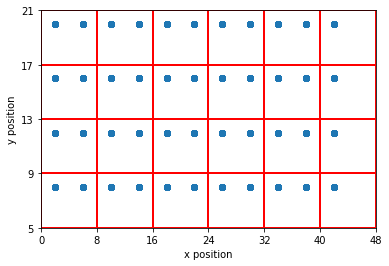

In [0]:
import pandas as pd
df = pd.read_csv("./IndoorFingerprint.csv")

import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(df["X"],df["Y"])

x_ticks = np.arange(0, 49, 8)
y_ticks = np.arange(5, 22, 4)
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.grid(color='r', linestyle='-', linewidth=2)
plt.ylabel("y position")
plt.xlabel("x position")
plt.show()

Donde los puntos azules son los distintos datos superpuestos de las posiciones del objeto a localizar. Por ejemplo el punto (2,8) está en la primera zona (o en la primera zona del eje *x* y del eje *y*), el punto (2,20) está en la zona 19 (o en la primera zona del eje *x* y la cuarta zona del eje *y*). Esta discretización transforma el problema que en un principio podría ser de regresión para determinar la posición exacta, en un problema de clasificación dividiendo (dentro de los posibles valores) 6 zonas para el eje "*x*" y 4 zonas para el eje "*y*", contando con un total de 24 clases (24 zonas en la malla).

> Deberá entrenar una red neuronal *feed forward* para la clasificación de las 24 posibles clases, con el objetivo de tener un desempeño (*accuracy*) mayor al 75%.
#### Importante
El conjunto de pruebas está **fijado** a través de los indices de posiciones del dataset, por lo que deberá leer estos indices y crear el conjunto de pruebas a partir de éstos.
```python
mask_test = np.loadtxt('mask_test.csv',dtype="i")
X_test = X[mask_test]
X_train = np.delete(X,mask_test,axis=0)
```
<div class="alert alert-block alert-info">Es una buena práctica el normalizar los datos antes de trabajar con los modelos</div>

<a id="refs"></a>
## Referencias
[1] Glorot, X., & Bengio, Y. (2010, March). *Understanding the difficulty of training deep feedforward neural networks*. In Proceedings of the thirteenth international conference on artificial intelligence and statistics (pp. 249-256).    
[2]  He, K., Zhang, X., Ren, S., & Sun, J. (2015). *Delving deep into rectifiers: Surpassing human-level performance on imagenet classification*. In Proceedings of the IEEE international conference on computer vision (pp. 1026-1034).  
[3] Krizhevsky, A., & Hinton, G. (2009). Learning multiple layers of features from tiny images.